<a href="https://colab.research.google.com/github/brandontan99/Identity-Verification-with-Masked-Face/blob/master/Identity_Verification_with_Masked_Face_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!gdown --id 1UlOk6EtiaXTHylRUx2mySgvJX9ycoeBp
!unzip RMFD.zip

In [2]:
!pip install facenet-pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from PIL import Image

seed = 0
dir_path = '/content/drive/MyDrive/Soft Computing/'
maskDF_path = dir_path + 'mask_df.pickle'


     |████████████████████████████████| 1.9MB 3.0MB/s 


# Data Preparation

In [ ]:
# create a dataframe with columns (image_path (str), mask (bool), person (str))
# save the dataframe into a pickle file
datasetPath = '/content/self-built-masked-face-recognition-dataset/'
maskPath = datasetPath + 'AFDB_masked_face_dataset/'
nonMaskPath = datasetPath + 'AFDB_face_dataset/'

maskDF = pd.DataFrame()

for subject in tqdm(os.listdir(nonMaskPath), desc='non mask photos'):
    for imgPath in os.listdir(nonMaskPath+subject):
        full_image_path = nonMaskPath+subject+"/"+imgPath
        maskDF = maskDF.append({
            'image_path': full_image_path,
            'mask': 0,
            'person': subject
        }, ignore_index=True)

for subject in tqdm(os.listdir(maskPath), desc='mask photos'):
    for imgPath in os.listdir(maskPath+subject):
        full_image_path = maskPath+subject+"/"+imgPath
        maskDF = maskDF.append({
            'image_path': full_image_path,
            'mask': 1,
            'person': subject
        }, ignore_index=True)

maskDF.to_pickle(maskDF_path)
maskDF

In [46]:
# load the dataframe from the pickle file saved in the previous cell
maskDF = pd.read_pickle(maskDF_path)
# apply label encoding to the "person" column for numerical processing
maskDF["person_encoded"] = maskDF["person"].to_frame().apply(LabelEncoder().fit_transform)
batch_size = 128
epochs = 8
workers = 0 if os.name == 'nt' else 8
maskDF

,image_path,mask,person,person_encoded
0,/content/self-built-masked-face-recognition-da...,0.0,maqiguang,249
1,/content/self-built-masked-face-recognition-da...,0.0,maqiguang,249
2,/content/self-built-masked-face-recognition-da...,0.0,maqiguang,249
3,/content/self-built-masked-face-recognition-da...,0.0,maqiguang,249
4,/content/self-built-masked-face-recognition-da...,0.0,maqiguang,249
...,...,...,...,...
92666,/content/self-built-masked-face-recognition-da...,1.0,zoushiming,536
92667,/content/self-built-masked-face-recognition-da...,1.0,zoushiming,536
92668,/content/self-built-masked-face-recognition-da...,1.0,xuzheng,422
92669,/content/self-built-masked-face-recognition-da...,1.0,zhouxingchi,526


In [47]:
# Determine if an nvidia GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [48]:
# define the dataset class
class RMFDataset(Dataset):
    def __init__(self, dataFrame, mtcnn = None):
        self.dataFrame = dataFrame
        self.num_of_classes = dataFrame["person_encoded"].max()+1
        self.transformations = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((100, 100)),
            transforms.ToTensor()
        ])
        self.mtcnn = mtcnn
    
    def __getitem__(self, key):
        row = self.dataFrame.iloc[key]
        image = np.array(Image.open(row['image_path']).convert('RGB'))

        if self.mtcnn:
          # to detect and crop the face image
          image = self.mtcnn(image)

        return self.transformations(image), torch.tensor(row["person_encoded"], dtype=int)
    
    def __len__(self):
        return len(self.dataFrame.index)

In [49]:
dataset = RMFDataset(maskDF)

# Define Model and Hyperparameters

In [50]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=dataset.num_of_classes
).to(device)

### Define Optimizer and Data Loader

In [51]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_size = int(0.8 * len(img_inds))
train_inds = img_inds[:train_size]
test_inds = img_inds[train_size:]
print("Number of train set:", train_size)
print("Number of test set:", len(img_inds) - train_size)
    
train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
test_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(test_inds)
)

Number of train set: 74136
Number of test set: 18535


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


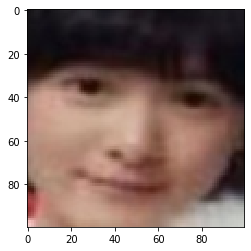

In [35]:
# to checkout one of the face images in the dataset
img = next(iter(train_loader))[0][0]
plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')

### Define loss and evaluation metric

In [52]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

# Training

In [53]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, test_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, test_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Valid |   145/145  | loss:    7.9625 | fps:  715.1898 | acc:    0.0012   

Epoch 1/8
----------
Train |   580/580  | loss:    3.6131 | fps:  217.5002 | acc:    0.2507   
Valid |   145/145  | loss:    2.4461 | fps:  702.1687 | acc:    0.4394   

Epoch 2/8
----------
Train |   580/580  | loss:    1.8269 | fps:  217.8035 | acc:    0.5774   
Valid |   145/145  | loss:    1.6466 | fps:  702.6971 | acc:    0.6251   

Epoch 3/8
----------
Train |   580/580  | loss:    1.2486 | fps:  218.5820 | acc:    0.7041   
Valid |   145/145  | loss:    1.5027 | fps:  714.9788 | acc:    0.6627   

Epoch 4/8
----------
Train |   580/580  | loss:    0.9052 | fps:  218.3185 | acc:    0.7821   
Valid |   145/145  | loss:    1.3902 | fps:  715.6150 | acc:    0.6963   

Epoch 5/8
----------
Train |   580/580  | loss:    0.6745 | fps:  218.4949 | acc:    0.8317   
Valid |   145/145  | loss:    1.3868 | fps:  709.5382 | acc:    0.7011   

Epoch 6/8
----------
Train |   580/580  | loss:    0.2730 | fps:  218.3511 

# Save Model

In [54]:
# save the model weights
model_save_name = dir_path + 'soft_com.pt'
torch.save(resnet.state_dict(), model_save_name)

# Load Model

In [57]:
# load the model weights
resnet= InceptionResnetV1(
    classify=True,
    num_classes=dataset.num_of_classes
).to(device)
model_save_name = dir_path + 'soft_com.pt'
resnet.load_state_dict(torch.load(model_save_name, map_location=device))
resnet.classify = False

# Evaluation

### Pre-Trained model to crop the face from the image

In [55]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

### Croppped Unmasked Passport Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


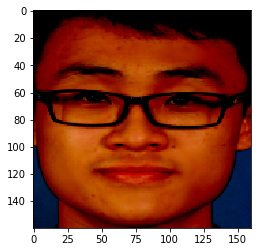

In [56]:
img = cv2.imread(dir_path + "Brandon Tan Zhirong.jpg")
img[:, :, [0, 2]] = img[:, :, [2, 0]]
plt.imshow(np.transpose(mtcnn(img), (1, 2, 0)), interpolation='nearest')

### Croppped Masked Passport Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


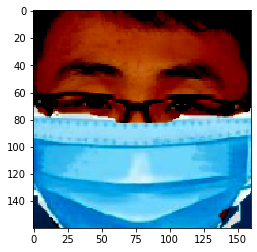

In [58]:
img = cv2.imread(dir_path + "Brandon Tan Zhirong (masked).png")
img[:, :, [0, 2]] = img[:, :, [2, 0]]
plt.imshow(np.transpose(mtcnn(img), (1, 2, 0)), interpolation='nearest')

### Define the Data Loader

In [59]:
test_maskDF = pd.DataFrame()
test_maskDF = test_maskDF.append({
            'image_path': dir_path + "Brandon Tan Zhirong.jpg",
            'mask': 0,
            'person_encoded': 1
        }, ignore_index=True)
test_maskDF = test_maskDF.append({
            'image_path': dir_path + "Brandon Tan Zhirong (masked).png",
            'mask': 1,
            'person_encoded': 1
        }, ignore_index=True)

In [60]:
test_dataset = RMFDataset(test_maskDF, mtcnn = mtcnn)
test_loader = DataLoader(
    test_dataset,
    num_workers=0,
    batch_size= 1
)

### Evaluate My Passport Photos

In [61]:
results = []
resnet.eval()
for img, person in test_loader:
  img = img.to(device)
  result = resnet(img)
  results.append(result.cpu().detach().numpy())

### **[Cosine Similarity]** Check the similiary between unmasked and masked image of my passport photo

In [62]:
similarity = 1 - cosine(results[0],results[1])
print("The similarity between unmasked and masked image is", round(similarity*100,2),"%")

The similarity between unmasked and masked image is 71.1 %
